# Main Pre-processing File

This main Python script serves several purposes, primarily for pre-processing.

We start off with quite a few inputs, then we have a giant nested loop that randomly generates particles until the criteria is met by these initial inputs (roughly the correct %CAM), finally we write the last iteration of particle's positions to a write.txt data file to be read by LAMMPS, a in.pour to be used as the script for this data file, and lastly we create some visuals of the final size/frequency distributions

In [5]:
import numpy
from numpy.random import default_rng
import math
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

First, we define material properties, and develop some initial relationships between target wt/vol based on the given densities

In [6]:
CAM_rho = 4.74 # density of CAM
SE_rho = 2.07 # density of SE
rho_ratio = CAM_rho / SE_rho # ratio b/w densities
target_carbon_ratio = 0.00 # carbon : ZERO for now
target_cam_weight = 0.66 * (1-target_carbon_ratio) # number in front = percentage of total # aiming for 66% CAM
target_se_weight = ( 1 - target_cam_weight  ) * ( 1 - target_carbon_ratio ) - 0.03 # - 5%  Shi Et Al, 3% CM
vol_cam = target_cam_weight / CAM_rho # volume of cam, total
vol_se = target_se_weight / SE_rho # volume of se, total
CAM_vol = vol_cam / (vol_cam+vol_se) # volume ratio of CAM among all the atoms
SE_vol = vol_se / (vol_cam+vol_se) # same ratio but for SE
CAM_E = 90000000 #90 GPa from lit
SE_E = 25000000 #20-30 GPa is from lit, used avg
CAM_v = 0.3 #lit
SE_v = 0.3 #lit

**Calculate_sigma** returns sigma based on the D5/D95 provided by the manufacturer

We assume a normal distribution (in this case), and calculate standard deviation from there 

Parameters: mu (float): Mean of the distribution.

d5 (float): The 5th percentile of the distribution.

d95 (float): The 95th percentile of the distribution.

Returns: float: The calculated standard deviation (sigma).

In [7]:
def calculate_sigma(mu: float, d5: float, d95: float) -> float:
    # z-scores for D5 and D95
    z_D5 = stats.norm.ppf(0.05)  # 5th percentile
    z_D95 = stats.norm.ppf(0.95)  # 95th percentile
    # Calculate sigma using D5 and D95
    sigma_D5 = (d5 - mu) / z_D5
    sigma_D95 = (d95 - mu) / z_D95
    # Average of the two sigmas
    sigma = (sigma_D5 + sigma_D95) / 2 #avging difference, if any
    return sigma

**Material Distrbutions** -- we're defining the mins/max of both particle types, as well as mu/sigma, the (approximate // initial estimation) volume per particle, and the probability % of each point being a CAM particle

In [8]:
CAM_mu = 11 #avg size of CAM, in this example only 1 size
CAM_D5 = 5.7#from provider
CAM_D95 = 20.4#from provider
CAM_sigma = calculate_sigma(CAM_mu, CAM_D5, CAM_D95)
CAM_min = CAM_D5 #legacy: we can change this to encompass 0-100 as well
CAM_max = CAM_D95 #but for now (since we dont know those) using 5-95
SE_mu = 1 #from provider
SE_D5 = 0.6 #these are made up -- but allow for a binormal dist
SE_D95 = 1.4 #similarly made up, opposite difference
SE_sigma = calculate_sigma(SE_mu, SE_D5, SE_D95)/2
SE_min = SE_D5
SE_max = SE_D95
CAM_pvol = CAM_mu**3 * 3.141592653 / 6 #vol per particle
SE_pvol = SE_mu**3 * 3.141592653 / 6
probability_CAM = (CAM_vol/CAM_pvol) / (CAM_vol/CAM_pvol + SE_vol/SE_pvol) #find probability

**Discretization** -- we're going to discretize both the the box, and the number of bins for our 'normal' and 'binormal' distributions

In [9]:
design_length = 35 #for tower, x and y coords
disc = 18 # # of points to discretize in x/y direction
test_ratio = 1 #initialize assumption about % CAM
iter = 0 #initialize iteration count
towerheight = 12 # how much taller is this tower, ratio of Z to X/Y
discrange = math.ceil(disc*disc*disc*towerheight) #add tower factor
atomID = 0 #iterable # these following vars are all variables for preparing LAMMPS readables/script
atom_id = numpy.zeros(discrange)
atom_type = numpy.zeros(discrange)
atom_diameter = numpy.zeros(discrange)
atom_density = numpy.zeros(discrange)
atom_mass = numpy.zeros(discrange)
x = numpy.zeros(discrange)
y = numpy.zeros(discrange)
z = numpy.zeros(discrange)
sizedisc = 10  # Update size discretization here
Earray = numpy.zeros(sizedisc*2) # array of Youngs modulus for easier reading/writing
for i in range(sizedisc):
    Earray[i] = CAM_E
    Earray[i + sizedisc] = SE_E
CAM_space = numpy.linspace(CAM_min, CAM_max, sizedisc) # discretized sizes
SE_space = numpy.linspace(SE_min, SE_max, sizedisc)
CAM_pdf_values = scipy.stats.norm.pdf(CAM_space, CAM_mu, CAM_sigma) # Compute PDF values
CAM_pdf_values /= CAM_pdf_values.sum() # Normalize to get a probability distribution
CAM_cdf_values = numpy.cumsum(CAM_pdf_values) # Compute cumulative sum
# same idea for SE but also need to make binormal distribution
SE_mu1 = 0.8 # or we could write (SE_D5 + SE_mu)/2
SE_sigma1 = SE_sigma
SE_mu2 = 1.2 # (SE_D95 + SE_mu)/2
SE_sigma2 = SE_sigma
SE_ratio1 = 0.5 # ratio of these two normal dists (50 to create true unskewed binormal)
SE_space = numpy.linspace(SE_D5, SE_D95, sizedisc)
SE_pdf_values1 = scipy.stats.norm.pdf(SE_space, SE_mu1, SE_sigma1)
SE_pdf_values2 = scipy.stats.norm.pdf(SE_space, SE_mu2, SE_sigma2)
SE_pdf_values = SE_ratio1 * SE_pdf_values1 + (1 - SE_ratio1) * SE_pdf_values2
SE_pdf_values /= SE_pdf_values.sum()
SE_cdf_values = numpy.cumsum(SE_pdf_values)

**Main nested loop** -- uses RNG to decide if next particle is CAM/SE, then RNG again to determine what size bin it falls into

In [10]:
rng = default_rng(11211995)
while test_ratio > (CAM_vol+0.02):
    atomID = 0
    atom_id = numpy.zeros(discrange)
    atom_type = numpy.zeros(discrange)
    atom_type2 = numpy.zeros(2 * sizedisc)
    atom_diameter = numpy.zeros(discrange)
    atom_density = numpy.zeros(discrange)
    x = numpy.zeros(discrange)
    y = numpy.zeros(discrange)
    z = numpy.zeros(discrange)
    atom_E = numpy.zeros(discrange)
    atom_gamma = numpy.zeros(discrange)
    atom_v = numpy.zeros(discrange)
    CAM_diameters = []
    SE_diameters = []
    test_CAM_no = 0 # reinitialize
    test_SE_no = 0 # these are all for debugging, showing # of each
    test_CAM_vol = 0 # showing VOL of each
    test_SE_vol = 0
    test_ratio = 1
    for i in range (1,(disc+1)):
        for j in range(1, (disc + 1)):
            for k in range(1, (math.ceil(disc*towerheight)+1)): #add tower factor
                atom_id[atomID] = atomID + 1
                x[atomID] = i*(design_length*.98/disc)+0.1 # a little extra / off from edges
                y[atomID] = j*(design_length*.98/disc)+0.1
                z[atomID] = k*(design_length*.98/disc)+0.1
                pick = rng.random()# random sample (0.0~1.0), probability of atom to be CAM
                if pick <= probability_CAM: # if its within probability cam %
                    atom_density[atomID] = CAM_rho # say its CAM
                    pick2 = rng.random()# 2nd rando for "what size CAM"
                    l = numpy.searchsorted(CAM_cdf_values, pick2) # L based on CAM CDF
                    atom_diameter[atomID] = CAM_space[l] # assign size based on said L
                    CAM_diameters.append(CAM_space[l]) # for plotting
                    atom_type[atomID] = l+1  # Here atom_type will be 1, 2, ..., sizedisc based on selected diameter for CAM
                    test_CAM_no = test_CAM_no + 1 # count, for debugging, vol for debugging below
                    test_CAM_vol = test_CAM_vol + atom_diameter[atomID]*atom_diameter[atomID]*atom_diameter[atomID]*3.141592653/6
                else: # same exact process for SE
                    atom_density[atomID] = SE_rho
                    pick2 = rng.random()
                    l = numpy.searchsorted(SE_cdf_values, pick2)
                    atom_diameter[atomID] = SE_space[l]
                    SE_diameters.append(SE_space[l])
                    atom_type[atomID] = l+1+sizedisc
                    test_SE_no = test_SE_no + 1
                    test_SE_vol = test_SE_vol + atom_diameter[atomID]*atom_diameter[atomID]*atom_diameter[atomID]*3.141592653/6
                atom_mass[atomID] = atom_diameter[atomID]*atom_diameter[atomID]*atom_diameter[atomID]*atom_density[atomID]*3.141592653/6
                atomID = atomID+1
        test_ratio = test_CAM_vol / (test_CAM_vol + test_SE_vol) #update CAM ratio, check if it's acceptable
        iter = iter + 1 #count iterations
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$
print('No. of CAM: '+str(test_CAM_no)+' No. of SE: ' + str(test_SE_no))
print('CAM vol: ' + str(test_CAM_vol)+' SE vol: ' + str(test_SE_vol))
print('CAM ratio by vol: ' +str(test_ratio))
weight_ratio = test_CAM_vol * CAM_rho / (test_CAM_vol * CAM_rho + test_SE_vol * SE_rho)
print('CAM ratio by weight: ' +str(weight_ratio))
stress = 375 #MPa
force = stress * (design_length/1000000) * (design_length/1000000) * 1e15 #conversion factor
CAM_force = force * test_ratio #splits the total force among CAM/SE by ratio
SE_force = force * (1-test_ratio)
CAM_p_force = CAM_force/test_CAM_no #splits total force per type to each particle
SE_p_force = SE_force/test_SE_no

No. of CAM: 48 No. of SE: 69936
CAM vol: 39064.71090775675 SE vol: 42198.307413805196
CAM ratio by vol: 0.4807194184342954
CAM ratio by weight: 0.6794679822156986


**Writes write.txt** -- creates the input file for LAMMPS

In [11]:
with open('write.txt', 'w') as f:
    f.write('Comment: ' + str(test_CAM_no) + ' CAM, ' + str(test_SE_no))
    f.write('\n')
    f.write(str(atomID)+' atoms')
    f.write('\n')
    f.write(str(sizedisc*2)+' atom types')
    f.write('\n')
    f.write('\n')
    f.write('0 '+str(design_length)+' xlo xhi')
    f.write('\n')
    f.write('0 '+str(design_length)+' ylo yhi')
    f.write('\n')
    f.write('0 '+str(design_length*towerheight)+' zlo zhi')
    f.write('\n')
    f.write('\n')
    f.write('Atoms')
    f.write('\n')
    f.write('\n')
    for i in range(0, (discrange )):
        f.write(str(int(atom_id[i]))+' '+str(int(atom_type[i]))+' '+str(atom_diameter[i])+' '+str(atom_density[i])+' '+str(x[i])+' '+str(y[i])+' '+str(z[i]))
        f.write('\n')

**Writes in.pour** -- creates the script (which references aforementioned write.txt) for LAMMPS

In [12]:
with open('in.pour', 'w') as g:
    g.write('atom_style	sphere')
    g.write('\n')
    g.write('boundary	p p fm')
    g.write('\n')
    g.write('newton		off')
    g.write('\n')
    g.write('comm_modify	vel yes')
    g.write('\n')
    g.write('units		micro')
    g.write('\n')
    g.write('\n')
    g.write('read_data write.txt')
    g.write('\n')
    g.write('\n')
    g.write('variable	xm 	equal '+str(design_length))
    g.write('\n')
    g.write('variable	ym 	equal '+str(design_length))
    g.write('\n')
    g.write('variable	zm 	equal '+str(design_length*towerheight))
    g.write('\n')
    g.write('\n')
    g.write('region		reg block 0 ${xm} 0 ${ym} 0 ${zm} units box')
    g.write('\n')
    g.write('neighbor	0.2 bin')
    g.write('\n')
    g.write('pair_style granular')
    g.write('\n')
    for i in range(2 * sizedisc):
        for j in range(i, 2 * sizedisc):
            E_value = ((1 - CAM_v * CAM_v) / (Earray[i]) + (1 - SE_v * SE_v) / Earray[j]) ** (-1)
            g.write('pair_coeff ' + str(i + 1) + ' ' + str(j + 1) + ' hertz/material ' + str(
                E_value) + ' 0.05 0.3 tangential mindlin NULL 1.0 0.4\n')
    g.write('\n')
    g.write('timestep	0.00005')
    g.write('\n')
    g.write('neigh_modify one 10000')
    g.write('\n')
    g.write('fix		1 all nve')
    g.write('\n')
    g.write('fix		zlower all wall/gran granular hertz/material '+str(CAM_E)+' 90000 ' +str(CAM_v)+' tangential mindlin NULL 1.0 0.4 limit_damping zplane 0.0 0.0')
    g.write('\n')
    g.write('region		slab block 0.0 ${xm} 0.0 ${ym} 0.0 ${zm} units box')
    g.write('\n')
    g.write('compute		1 all erotate/sphere')
    g.write('\n')
    g.write('thermo_style	custom step atoms ke c_1 vol')
    g.write('\n')
    g.write('thermo		100')
    g.write('\n')
    g.write('thermo_modify	lost ignore norm no')
    g.write('\n')
    g.write('compute_modify	thermo_temp dynamic/dof yes')
    g.write('\n')
    g.write('dump		id all atom 100 dump.pour')
    g.write('\n')
    g.write('dump		2 all image 500 image.*.jpg type type axes yes 0.8 0.02 view 80 -30')
    g.write('\n')
    g.write('dump_modify	2 pad 5')
    g.write('\n')
    cam_string = ' '.join(str(j) for j in range(1, sizedisc + 1))
    SE_string = ' '.join(str(j) for j in range(sizedisc + 1, 2 * sizedisc + 1))
    g.write('group CAM type ' + str(cam_string))
    g.write('\n')
    g.write('group SE type ' + str(SE_string))
    g.write('\n')
    g.write('fix        4 CAM addforce 0 0 -' + str(CAM_p_force))
    g.write('\n')
    g.write('fix		4 SE addforce 0 0 -' + str(SE_p_force))
    g.write('\n')
    # Write a restart file every 10000 steps
    g.write('restart 10000 restart.*')
    g.write('\n')
    g.write('run		100000')
    g.write('\n')

**Plot** our frequency vs diameter graphs for both particles

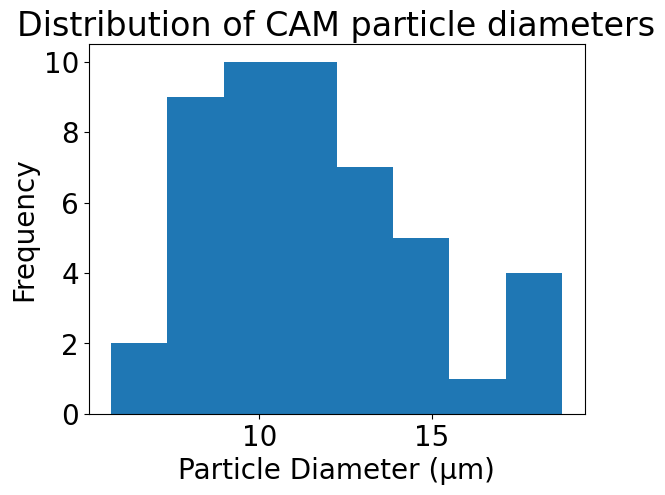

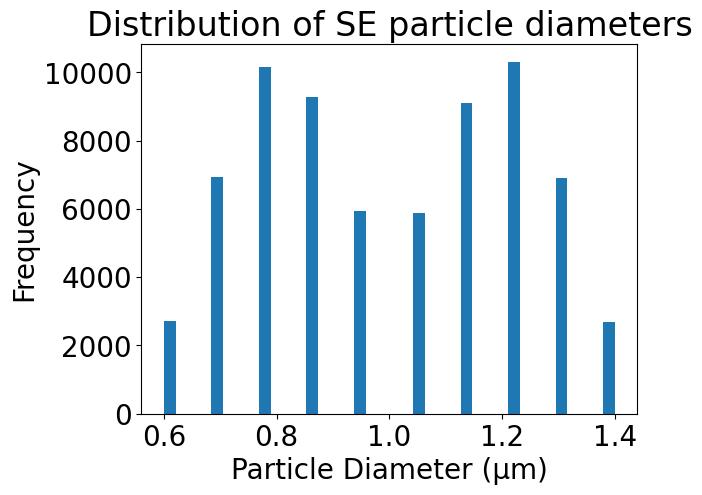

In [13]:
plt.rcParams.update({'font.size': 20})
plt.hist(CAM_diameters, bins='auto')
plt.xlabel('Particle Diameter (μm)')
plt.ylabel('Frequency')
plt.title('Distribution of CAM particle diameters')
plt.show()
plt.hist(SE_diameters, bins='auto')
plt.xlabel('Particle Diameter (μm)')
plt.ylabel('Frequency')
plt.title('Distribution of SE particle diameters')
plt.show()